## Deep face recognition with Keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Set files_zip_path to the location in the drive where you have the new `'Files_required_for_face_recognition.zip'` file. This block will extract all the files to the current working directory. You should be seeing the list of all files inside the zip files as the output of this block after the final `!ls` command is executed. 

In [0]:
files_zip_path = "/content/drive/My Drive/Files_required_for_face_recognition.zip"

import zipfile
#This extracts the files to the current working directory
archive = zipfile.ZipFile(files_zip_path, 'r')
archive.extractall()
!ls

### First, lets install the required libraries. Upload the `requirements.txt` file given and run the below commands.

In [3]:
import os
os.chdir('/content/drive/My Drive/ACV_P2/files_required_for_face_recognition')
!pip install -r requirements.txt --user

     |████████████████████████████████| 81kB 24.0MB/s 
     |████████████████████████████████| 5.4MB 35.2MB/s 
     |████████████████████████████████| 890kB 21.2MB/s 
     |████████████████████████████████| 256kB 44.1MB/s 
     |████████████████████████████████| 133kB 52.2MB/s 
     |████████████████████████████████| 92kB 35.3MB/s 
     |████████████████████████████████| 327kB 53.4MB/s 
     |████████████████████████████████| 81kB 32.8MB/s 
     |████████████████████████████████| 15.0MB 40.3MB/s 
     |████████████████████████████████| 389kB 54.4MB/s 
     |████████████████████████████████| 8.0MB 41.6MB/s 
     |████████████████████████████████| 17.2MB 44.4MB/s 
     |████████████████████████████████| 24.9MB 1.5MB/s 
     |████████████████████████████████| 92kB 33.8MB/s 
     |████████████████████████████████| 61kB 30.3MB/s 
     |████████████████████████████████| 256kB 57.0MB/s 
     |████████████████████████████████| 6.4MB 50.3MB/s 
     |████████████████████████████████| 849kB 52.1M

In [4]:
!pip install request

  Stored in directory: /root/.cache/pip/wheels/30/84/5f/484cfba678967ef58c16fce6890925d5c7172622f20111fbfd
  Stored in directory: /root/.cache/pip/wheels/c1/e3/c1/d02c8c58538853e4c9b78cadb74f6d5c5c370b48a69a7271aa
  Stored in directory: /root/.cache/pip/wheels/c3/c3/24/b5c132b537ab380c02d69e6bd4dec1f5db56b5fe19030473d7
  Stored in directory: /root/.cache/pip/wheels/d6/a4/78/01b20a9dc224dcc009fab669f7f27b943b8889c5150bd68d8a
  Stored in directory: /root/.cache/pip/wheels/23/7c/6e/f5b4e09d6596c8b8802b347e48f149031e2363368048f1347a
Successfully built request get post query-string public


### Training the network

The CNN model is taken from the Keras-OpenFace project. The architecture details aren't too important here, it's only useful to know that there is a fully connected layer with 128 hidden units followed by an L2 normalization layer on top of the convolutional base. These two top layers are referred to as the embedding layer from which the 128-dimensional embedding vectors can be obtained. The complete model is defined in `model.py` and a graphical overview is given in `model.png`. A Keras version of the `nn4.small2` model can be created with `create_model()`.


**Run the below code to initialize the model**

In [5]:
import os
os.chdir('/content/drive/My Drive/ACV_P2/files_required_for_face_recognition')
from model import create_model
#Disable tensorflow backend warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

nn4_small2 = create_model()

Using TensorFlow backend.
W0616 04:24:49.329168 140105577269120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0616 04:24:49.373051 140105577269120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0616 04:24:49.383493 140105577269120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0616 04:24:49.421066 140105577269120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0616 

#### Idea of Training the model with Triplet loss function 

Model training aims to learn an embedding f(x) of image x such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large. This can be achieved with a triplet loss L that is minimized when the distance between an anchor image xai and a positive image xpi (same identity) in embedding space is smaller than the distance between that anchor image and a negative image xni (different identity) by at least a margin α.

In [0]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer

# Input for anchor, positive and negative images
in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

In [7]:
from data import triplet_generator

# triplet_generator() creates a generator that continuously returns 
# ([a_batch, p_batch, n_batch], None) tuples where a_batch, p_batch 
# and n_batch are batches of anchor, positive and negative RGB images 
# each having a shape of (batch_size, 96, 96, 3).
generator = triplet_generator() 

nn4_small2_train.compile(loss=None, optimizer='adam')
nn4_small2_train.fit_generator(generator, epochs=10, steps_per_epoch=100)

# Please note that the current implementation of the generator only generates 
# random image data. The main goal of this code snippet is to demonstrate 
# the general setup for model training. In the following, we will anyway 
# use a pre-trained model so we don't need a generator here that operates 
# on real training data.

W0616 04:25:17.925301 140105577269120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0616 04:25:18.049396 140105577269120 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
100/100 [==============================] - 27s 266ms/step - loss: 0.8044
Epoch 2/10
100/100 [==============================] - 10s 98ms/step - loss: 0.8034
Epoch 3/10
100/100 [==============================] - 10s 99ms/step - loss: 0.7997
Epoch 4/10
100/100 [==============================] - 10s 98ms/step - loss: 0.8005
Epoch 5/10
100/100 [==============================] - 10s 97ms/step - loss: 0.8003
Epoch 6/10
100/100 [==============================] - 10s 97ms/step - loss: 0.8003
Epoch 7/10
100/100 [==============================] - 10s 98ms/step - loss: 0.8002
Epoch 8/10
100/100 [==============================] - 10s 97ms/step - loss: 0.8001
Epoch 9/10
100/100 [==============================] - 10s 97ms/step - loss: 0.8001
Epoch 10/10
100/100 [==============================] - 10s 98ms/step - loss: 0.8001


For this project, we are considering a pre-trained model given in file path **`nn4.small2.v1.h5`**.

# 1. Using **load_weights()** function load the given pre-trained weight file.

In [0]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('/content/drive/My Drive/ACV_P2/files_required_for_face_recognition/nn4.small2.v1.h5', by_name = True)

### Dataset

To demonstrate face recognition on a custom dataset, a small dataset is used. It consists of around 15-25 face images of 10 different persons. The metadata for each image (file and identity name) are loaded into memory for later processing.


Upload Images zip file given to drive and download and extract it using the below code. And we will pass the folder `images` to `load_metadata` function to save all the images filenames and person numbers.

#### Import drive module from google.colab

In [0]:
from google.colab import drive

#### Give a path to mount the files in your drive

#### Using the above given mounted path, give the images.zip path dependent on where you placed the file in your drive.

In [0]:
## For example
images_path = "/content/drive/My Drive/ACV_P2/files_required_for_face_recognition/images.zip"

#### Using ZipFile module to extract the images zip file

In [0]:
from zipfile import ZipFile

In [0]:
os.chdir('/content/drive/My Drive/ACV_P2/')
with ZipFile(images_path, 'r') as zip:
  zip.extractall()

#### Run the below function to load the images from the extracted images folder from the above step and map each image with person id 


In [0]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('images')

In [16]:
print(metadata[0].file)

image_0438.jpg


### Face Crop 
The nn4.small2.v1 model was trained with cropped face images, therefore, the face images from the custom dataset must be cropped too. Here, we use the face detection model we built in Milestone 2 and use it to detect faces and crop the faces to pass to our model.

##### 1. Import the pre-trained model from milestone 2. You would need all the python files required for the face-detection assignment and the trained weights as well


In [18]:
os.chdir('/content/drive/My Drive/ACV_P2/files_required_for_face_recognition')
from mn_model import mn_model
#from face_generator import BatchGenerator
from keras_ssd_loss import SSDLoss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2
from keras.models import load_model
from keras import backend as K

img_height =512
img_width = 512

img_channels = 3

n_classes =2 
class_names = ["background","face"]

scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # anchorboxes for coco dataset
aspect_ratios = [[0.5, 1.0, 2.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [0.5, 1.0, 2.0],
                 [0.5, 1.0, 2.0]] # The anchor box aspect ratios used in the original SSD300
two_boxes_for_ar1 = True
limit_boxes = True # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are scaled as in the original implementation
coords = 'centroids' # Whether the box coordinates to be used as targets for the model should be in the 'centroids' or 'minmax' format, see documentation
normalize_coords = True

model, model_layer, img_input, predictor_sizes = mn_model(image_size=(img_height, img_width, img_channels), 
                                                                      n_classes = n_classes,
                                                                      min_scale = None, 
                                                                      max_scale = None, 
                                                                      scales = scales, 
                                                                      aspect_ratios_global = None, 
                                                                      aspect_ratios_per_layer = aspect_ratios, 
                                                                      two_boxes_for_ar1= two_boxes_for_ar1, 
                                                                      limit_boxes=limit_boxes, 
                                                                      variances= variances, 
                                                                      coords=coords, 
                                                                      normalize_coords=normalize_coords)

#model.summary()
model_path = '/content/drive/My Drive/ACV_P2/files_required_for_face_recognition/'
model_name = 'ssd_mobilenet_face_epoch_25_loss0.0916.h5'

model.load_weights(model_path + model_name,  by_name= True)

====> Model Specific data
====> Height, Width, Channels : 512 512 3


##### 2. Function to load an image and reverse the channels for matplot lib to show them


In [0]:
os.chdir('/content/drive/My Drive/ACV_P2/images')
import cv2
def load_image(path):
    img = cv2.imread(path)
    b,g,r = cv2.split(img)       # get b,g,r
    img = cv2.merge([r,g,b])
    return img

You can access each image path from `metadata[i].image_path()` where, i is the image number. We can take values from 1 to no.of images in the dataset given and plot them using matplotlib's imshow.

images/1/image_0439.jpg


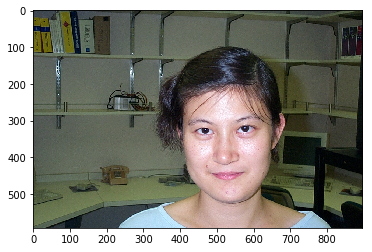

In [21]:
# Load an image
# for example, loading the image with index 1
import matplotlib.pyplot as plt
one_image = load_image('/content/drive/My Drive/ACV_P2/'+ metadata[1].image_path())
print(metadata[1].image_path())
%matplotlib inline
from google.colab.patches import cv2_imshow
plt.figure()
# Show original image
# OpenCV loads images with color channels
# in BGR order. So we need to reverse them everytime we use matplotlib to show the image.
# Otherwise you see the image in false colour
plt.imshow(one_image)


##### 3. A function to get the face bounding box x_min, x_max, y_min and y_max of input image using the face detection model given an image read using cv2.imread.


In [0]:
def face_bb(test_img):
    img_height =512
    img_width = 512
    img_channels = 3
    _CONF = 0.60
    _IOU = 0.15
    coords = 'centroids' # Whether the box coordinates to be used as targets for the model should be in the 'centroids' or 'minmax' format, see documentation
    normalize_coords = True
    org_height = test_img.shape[0]
    org_width = test_img.shape[1]
    test_img = cv2.resize(test_img, (512, 512))
    test_img_input = np.expand_dims(test_img,axis=0)
    y_pred = model.predict(test_img_input)
    y_pred_decoded = decode_y2(y_pred,
                                 confidence_thresh=_CONF,
                                iou_threshold=_IOU,
                                top_k='all',
                                input_coords=coords,
                                normalize_coords=normalize_coords,
                                img_height=img_height,
                                img_width=img_width)
    result = y_pred_decoded[0][0]
    det_label = result[0]
    det_conf = result[1]
    det_xmin = result[2]
    det_xmax = result[3]
    det_ymin = result[4]
    det_ymax = result[5]
    #Converting to integers as the indexes to images are only integers
    bb = [int(det_xmin),int(det_xmax),int(det_ymin),int(det_ymax)]
    return bb

# 2. Write a function to get the resized cropped out face of an input image from the path given using the face_bb() function defined above. - 5 Marks
Hint: The face_bb() function gives a list of bounding box co-ordinate values like **[x_min,x_max,y_min,y_max]**. Use **cv2.imread()** to load an image from the image path and pass it to the face_bb function as input. You can crop an image by simply accessing the specific values of the image matrix using the co-ordinates as the boundary indexes. But, before cropping we have to resize the input image to (512,512) like done in the **face_bb()** function as the bounding box co-ordinates are for the resized image. A simple crop can be implemented on the resized image by doing **"image[y_min:y_max,x_min:x_max,:]"** . 
You have to then resize the cropped image to a fixed size of (96,96). You can do that using the **cv2.resize()** function again. It takes the second argument as (96,96) this time. 

In [0]:
def get_face(img_path):
    
    img = load_image(img_path)
    x_min, x_max, y_min, y_max = face_bb(img)
    crop_img = cv2.resize(img, (512, 512))
    crop_img = crop_img[y_min:y_max,x_min:x_max,:]
    crop_img = cv2.resize(crop_img, (96,96))
    return crop_img

# 3. Write code to load 2nd and 3rd images in the metadata using load_image() and show each image and its cropped version side by side for comparison using matplotlib imshow - 7.5 Marks

In [0]:
images_path = '/content/drive/My Drive/ACV_P2/'
def comparison(images_path, filename):
  orig_img = load_image(images_path + filename)
  cropped_img = get_face(images_path + filename)
  fig,axes=plt.subplots(1,2)
  axes[0].imshow(orig_img)
  axes[1].imshow(cropped_img)
  fig=plt.gcf()
  fig.set_size_inches(10,10)
  fig.tight_layout()  

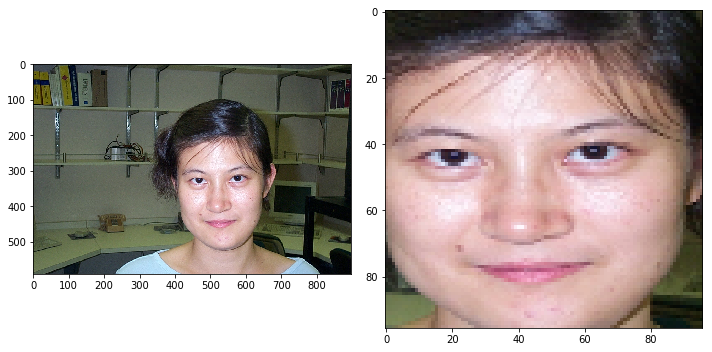

In [0]:
comparison(images_path, metadata[1].image_path())

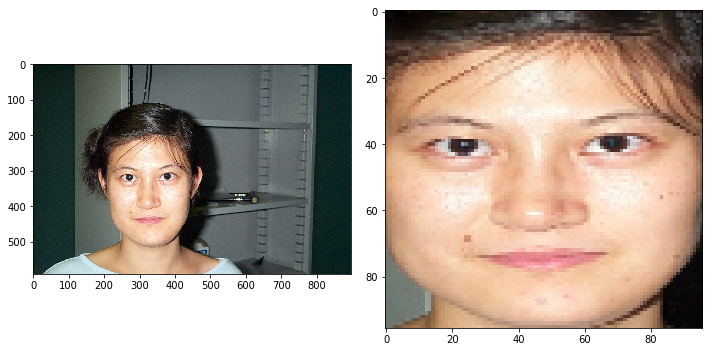

In [0]:
comparison(images_path, metadata[2].image_path())

### Generate embeddings for each image in the dataset

Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model. 

In [25]:
metadata.shape

(201,)

#### Get embedding vector for first image in the metadata using the pre-trained model

In [26]:
# Align the image
cropped_img = get_face(images_path + metadata[0].image_path())

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (cropped_img / 255.).astype(np.float32)

# obtain embedding vector for an image
embedding_vector = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]

print(embedding_vector.shape)

(128,)


# 4. Write code to iterate through metadata and create embeddings for each image using nn4_small2_pretrained.predict() and store in a list with name `embeddings` - 5 marks

If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 128-zeroes as the final embedding from the model is of length 128.
Hint: Don't forget to use numpy's expand_dims funtion to convert each image into the shape (1,96,96,3) and take the 0th element of the prediction from the model as the embedding of the image. 

In [27]:
metadata.shape

(201,)

In [28]:
def create_embeddings(img):
  cropped_img = get_face(images_path + img)
  img = (cropped_img / 255.).astype(np.float32)
  embedding_vector = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
  return embedding_vector
embeddings = []
for i in range(len(metadata)):
  embeddings.append(create_embeddings(metadata[i].image_path()))
print(len(embeddings))

201


#### Write code to get the distance between the respective embeddings given 2 pairs of images.

Consider distance metric as "Squared L2 distance"

squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2



# 5. Plot images and get distance between the pairs given below. - 5 Marks

1. 10,12 and 10,131

2. 30,31 and 30,100

3. 70,72 and 70,115

In [0]:
def sqrl2distance(img1, img2, cnt1, cnt2):
    l2dist = np.linalg.norm(img1-img2)
    fig,axes=plt.subplots(1,2)
    axes[0].imshow(load_image(images_path + metadata[cnt1].image_path()))
    axes[1].imshow(load_image(images_path + metadata[cnt2].image_path()))
    plt.suptitle('Distance between ' + str(cnt1) + ' and ' + str(cnt2) + ' is ' + str(l2dist))
    fig=plt.gcf()
    fig.set_size_inches(5,10)
    fig.tight_layout()  

Test 1 : (10, 12) vs (10, 131)

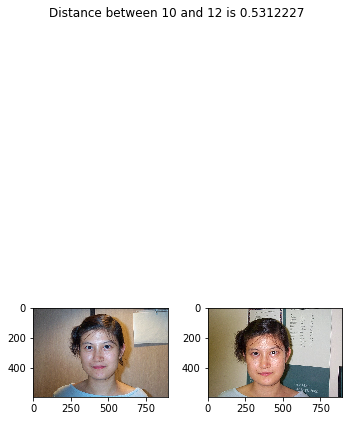

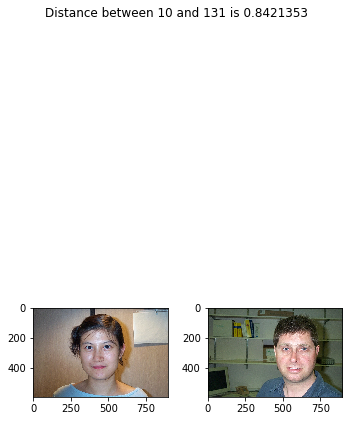

In [30]:
sqrl2distance(embeddings[10], embeddings[12], 10, 12)
sqrl2distance(embeddings[10], embeddings[131], 10, 131)

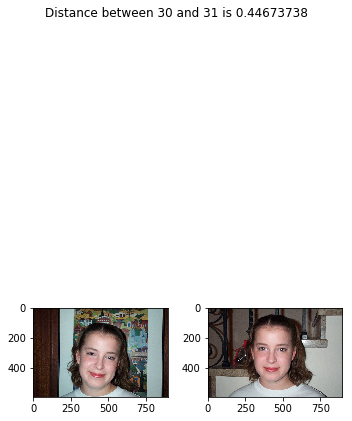

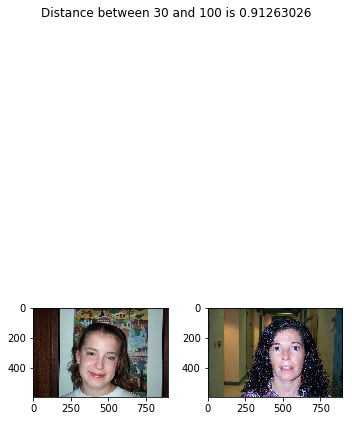

In [31]:
sqrl2distance(embeddings[30], embeddings[31], 30, 31)
sqrl2distance(embeddings[30], embeddings[100], 30, 100)

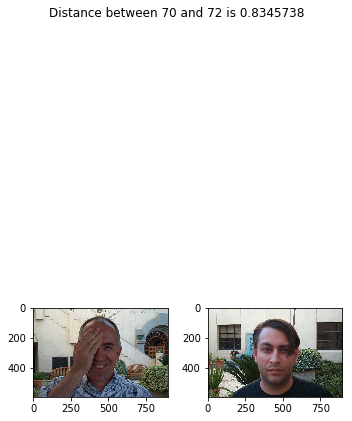

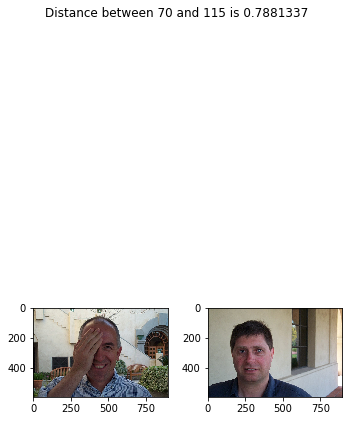

In [32]:
sqrl2distance(embeddings[70], embeddings[72], 70, 72)
sqrl2distance(embeddings[70], embeddings[115], 70, 115)

#### Now lets build a simple fully connected neural network classifier to predict person in the given image. 

If you observe distances between more pairs the difference is not constant between opposite pairs. So we train a fully connected neural network with very limited dataset to classiffy each embedding into the person. Lets prepare the data for training a fully connected neural network using keras

In [33]:
import keras

targets = np.array([int(m.name) for m in metadata])

num_classes = 11
# convert class vectors to one-hot encodings
y = keras.utils.to_categorical(targets, num_classes)

indices = np.arange(metadata.shape[0])
train_idx = indices[indices % 2 != 0]
test_idx =  indices[indices % 2 == 0]

## checking the shapes of metaadata and test and train sets
print(metadata.shape)
print(train_idx.shape)
print(test_idx.shape)

# one half as train examples of 10 identities
X_train = np.array([embeddings[i] for i in train_idx])
X_test = np.array([embeddings[i] for i in test_idx])


y_train = y[train_idx]
y_test = y[test_idx]



print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
# svc = LinearSVC()

(201,)
(100,)
(101,)
(100, 128)
(100, 11)
(101, 128)
(101, 11)


# 6. Build a 1 layered fully connected neural network using keras and report the accuracy - 7.5 marks
Hint: Create only one layer with 11 neurons as we have 11 classes and mention the input_dim as 128 as the embeddings are of 128 length. Use a small batch size like 4 and use softmax as the activation function of the layer. 
You might have to train upto 80 epochs to get decent accuracy. You can use an Adam optimizer for the training part

In [34]:
from keras.models import Model
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

model = Sequential()
model.add(Dense(11, activation='softmax',input_dim = 128))
# Loss and Optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=4, nb_epoch=150, 
              validation_data=(X_test, y_test))


Train on 100 samples, validate on 101 samples
Epoch 1/150
100/100 [==============================] - 4s 40ms/step - loss: 2.4107 - acc: 0.0800 - val_loss: 2.3689 - val_acc: 0.1683
Epoch 2/150
100/100 [==============================] - 0s 2ms/step - loss: 2.3511 - acc: 0.2100 - val_loss: 2.3185 - val_acc: 0.2970
Epoch 3/150
100/100 [==============================] - 0s 1ms/step - loss: 2.2976 - acc: 0.3000 - val_loss: 2.2719 - val_acc: 0.3663
Epoch 4/150
100/100 [==============================] - 0s 2ms/step - loss: 2.2508 - acc: 0.4200 - val_loss: 2.2275 - val_acc: 0.4158
Epoch 5/150
100/100 [==============================] - 0s 1ms/step - loss: 2.2054 - acc: 0.4900 - val_loss: 2.1866 - val_acc: 0.4653
Epoch 6/150
100/100 [==============================] - 0s 2ms/step - loss: 2.1610 - acc: 0.5800 - val_loss: 2.1482 - val_acc: 0.5545
Epoch 7/150
100/100 [==============================] - 0s 2ms/step - loss: 2.1210 - acc: 0.6000 - val_loss: 2.1115 - val_acc: 0.5446
Epoch 8/150
100/100 [=

# 7.  Test the classifier 

Take 35th image from test set and plot the image, report to which person(folder name in dataset) the image belongs to.

In [0]:
y_pred_35 = model.predict_classes(X_test[34:35])

In [36]:
print('Model predicted person number for 35th image: ', y_pred_35)
print ('Ground truth person number for 35th image: ', np.argmax(y_test[34]))

Model predicted person number for 35th image:  [8]
Ground truth person number for 35th image:  8


## Optional Exercise - For people who are familiar with SVMs, you can use an SVM classifier(If you already know how to use the scikit-learn package for it) to do this last part being done by the fully connected neural network.